In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [2]:
def get_group_place(df, matchId) :
    # 각 match 선택
    match_data = df[df['matchId'].values == matchId]
    num = match_data['maxPlace'].mean()
    
    if match_data['groupId'].nunique() == 1 : 
        gid = match_data['groupId'].values[0]
        final_dictionary.update({gid : 0})
        return 
    
    elif match_data['groupId'].nunique() == 2 :
        gids = match_data['groupId'].unique()
        g1 = gids[0]
        g2 = gids[1]
        g1_kills = match_data[match_data['groupId'].values == g1]['kills'].sum()
        if g1_kills == len(match_data[match_data['groupId'].values == g2]) : 
            final_dictionary.update({g1 : 1,
                                     g2 : 0})
        else : 
            final_dictionary.update({g1 : 0,
                                     g2 : 1})
        return 
        
    # solo or not 
    mtype = match_data['matchType'].iloc[0]
    
    # empty  
    Maxplace = match_data.iloc[0]['maxPlace']
    Numgroups = match_data.iloc[0]['numGroups']
    t = Maxplace - Numgroups
    pivot = int(np.round((Maxplace - t)/(t+1)))
    indices = []
    for i in range(1, t+1) : 
        indices.append(i*pivot)
    
    # kill별로 sort
    match_data = match_data.sort_values(by = ['kills', 'killPlace'])
    match_data = match_data[['kills', 'groupId', 'killPlace']]

    # 해당 kill에 해당하는 user가 1명인 경우 제외   
    kills_values = match_data['kills'].value_counts()
    kills_unique = kills_values[kills_values.values == 1].index.tolist()
    kills_unique_user = match_data[match_data['kills'].isin(kills_unique)]
    
    kill_type = kills_values.index
    
    ###
    if (match_data['kills'].value_counts() == 1).all() : 
        rank_dict_lst = match_data.groupby('groupId')['kills'].max().sort_values(ascending = False).index.tolist()
    
    else : 
        if 'solo' not in mtype : 
            match_data = match_data[~match_data['kills'].isin(kills_unique)]
            match_data = match_data.sort_values(by = ['kills', 'killPlace'], ascending = True)

        if 'solo' in mtype :
            group_lst = []
            kill_type = sorted(kill_type, reverse = True)

            for kt in kill_type :
                kill_data = match_data[match_data['kills'] == kt]
                kill_data = kill_data.sort_values(by = 'killPlace')
                group_lst =  group_lst + list(kill_data['groupId']) 


        kill_0 = match_data[match_data['kills'] == kill_type[0]][['killPlace', 'groupId']]
        kill_0 = kill_0.drop_duplicates(['groupId'])
        kill_0 = kill_0['groupId'].values

        loc_dict = {}
        rank_dict = {}    
        
        cetain_lst = []
        for i in range(len(kill_0)) : 
            groupId = kill_0[i]
            rank_dict[i] = [groupId]
            loc_dict[groupId] = i

        for kt in kill_type[1:] :
            kill_1 = match_data[match_data['kills'] == kt][['killPlace', 'groupId']]
            kill_1 = kill_1.drop_duplicates(['groupId'])
            kill_1 = kill_1['groupId'].values

            for i in range(len(kill_1)) : 
                cur_group = kill_1[i]
                if cur_group in loc_dict : 
                    continue 
                else : 
                    # upper bound 
                    refer_lst = kill_1[i:]
                    check_lst = [1 if r in loc_dict else 0 for r in refer_lst]
                    if any(check_lst) : 
                        r_index = check_lst.index(1)
                        r = loc_dict[refer_lst[r_index]]
                    else : 
                        for key, values in rank_dict.items() : 
                            if len(values) == 0 : 
                                r = key 
                                break
                            else :
                                r = Numgroups//2

                    # lower bound 
                    refer_lst = kill_1[:i]
                    check_lst = [1 if r in loc_dict else 0 for r in refer_lst]
                    if any(check_lst) : 
                        l_index = max([i for i in range(len(check_lst)) if check_lst[i] == 1])
                        l = loc_dict[refer_lst[l_index]]
                    else : 
                        l = 0

                    if (l+r)/2 in rank_dict : 
                        rank_dict[(l+r)/2].append(cur_group)
                    else : 
                        rank_dict[(l+r)/2] = [cur_group]
                    loc_dict[cur_group] = (l+r)/2


        rank_dict_lst = sorted(rank_dict.items())
        rank_dict_lst = [x[1] for x in rank_dict_lst]
        rank_dict_lst = sum(rank_dict_lst, [])

        for ku in kills_unique : 
            group_name = kills_unique_user[kills_unique_user['kills'] == ku]['groupId'].values[0]
            if group_name not in rank_dict_lst : 
                rank_dict_lst = [group_name] + rank_dict_lst
    rank_dict_lst_df = pd.DataFrame(rank_dict_lst)
    
    winPlace = np.linspace(0, 1, num = int(num), endpoint = True).tolist()
    winPlace = list(reversed(winPlace))
    remove_lst = [] 
    for idx in indices :
        remove_lst.append(winPlace[idx])
        
    for val in remove_lst : 
        if val in winPlace : 
            winPlace.remove(val)
        
    rank_dict_lst_df['pred_winPlace'] = pd.Series(winPlace)
    
    pred_dict = rank_dict_lst_df.set_index([0]).to_dict()['pred_winPlace']
    final_dictionary.update(pred_dict)
    return 

In [3]:
def preprocessing_func(df) : 
    df.drop(['killPoints', 'rankPoints', 'winPoints'], axis = 1, inplace = True)
    
    df['assists_mean'] = df.groupby('groupId')['assists'].transform('mean')
    df['assists_mean_rank'] = df.groupby('matchId')['assists_mean'].rank(pct = True)
    df['assists_max'] = df.groupby('groupId')['assists'].transform('max')
    df['assists_rank'] = df.groupby('matchId')['assists'].rank(pct = True)
    df['assists_group_rank'] = df.groupby('matchId')['assists_mean'].rank(pct = True)
    df['assists'] = [3 if x >= 3 else x for x in df['assists']]
    
    df['boosts_mean'] = df.groupby('groupId')['boosts'].transform('mean')
    df['boosts_mean_rank'] = df.groupby('matchId')['boosts_mean'].rank(pct = True)
    df['boosts_max'] = df.groupby('groupId')['boosts'].transform('max')
    df['boosts_rank'] = df.groupby('matchId')['boosts'].rank(pct = True)
    df['boosts'] = [8 if x >= 8 else x for x in df['boosts']]
    
    df['damageDealt_mean'] = df.groupby('groupId')['damageDealt'].transform('mean')
    df['damageDealt_mean_rank'] = df.groupby('matchId')['damageDealt_mean'].rank(pct = True)
    df['damageDealt_max'] = df.groupby('groupId')['damageDealt'].transform('max')
    df['damageDealt_rank'] = df.groupby('matchId')['damageDealt'].rank(pct = True)
    df['damageDealt'] = [923.9 if x >= 923.9 else x for x in df['damageDealt']]
    
    df['DBNOs_mean'] = df.groupby('groupId')['DBNOs'].transform('mean')
    df['DBNOs_mean_rank'] = df.groupby('matchId')['boosts_mean'].rank(pct = True)
    df['DBNOs_max'] = df.groupby('groupId')['DBNOs'].transform('max')
    df['DBNOs_rank'] = df.groupby('matchId')['DBNOs'].rank(pct = True)
    df['DBNOs'] = [6 if x >= 6 else x for x in df['DBNOs']]
    
    df['headshotKills_mean'] = df.groupby('groupId')['headshotKills'].transform('mean')
    df['headshotKills_mean_rank'] = df.groupby('matchId')['headshotKills_mean'].rank(pct = True)
    df['headshotKills_max'] = df.groupby('groupId')['headshotKills'].transform('max')
    df['headshotKills_rank'] = df.groupby('matchId')['headshotKills'].rank(pct = True)
    df['headshotKills'] = [3 if x >= 3 else x for x in df['headshotKills']]
    
    df['heals_mean'] = df.groupby('groupId')['heals'].transform('mean')
    df['heals_mean_rank'] = df.groupby('matchId')['heals_mean'].rank(pct = True)
    df['heals_max'] = df.groupby('groupId')['heals'].transform('max')
    df['heals_rank'] = df.groupby('matchId')['heals'].rank(pct = True)
    df['heals'] = [15 if x >= 15 else x for x in df['heals']]
    
    df['kills_mean'] = df.groupby('groupId')['kills'].transform('mean')
    df['kills_mean_rank'] = df.groupby('matchId')['kills_mean'].rank(pct = True)
    df['kills_max'] = df.groupby('groupId')['kills'].transform('max')
    df['kills_rank'] = df.groupby('matchId')['kills'].rank(pct = True)
    df['kills'] = [8 if x >= 8 else x for x in df['kills']]
    
    df['killStreaks_mean'] = df.groupby('groupId')['killStreaks'].transform('mean')
    df['killStreaks_mean_rank'] = df.groupby('matchId')['killStreaks_mean'].rank(pct = True)
    df['killStreaks_max'] = df.groupby('groupId')['killStreaks'].transform('max')
    df['killStreaks_rank'] = df.groupby('matchId')['killStreaks'].rank(pct = True)
    df['killStreaks'] = [3 if x >= 3 else x for x in df['killStreaks']]
    
    df['longestKill_mean'] = df.groupby('groupId')['longestKill'].transform('mean')
    df['longestKill_mean_rank'] = df.groupby('matchId')['longestKill_mean'].rank(pct = True)
    df['longestKill_max'] = df.groupby('groupId')['longestKill'].transform('max')
    df['longestKill_rank'] = df.groupby('matchId')['longestKill'].rank(pct = True)
    df['longestKill'] = [3 if x >= 3 else x for x in df['longestKill']]
    
    df['revives_mean'] = df.groupby('groupId')['revives'].transform('mean')
    df['revives_mean_rank'] = df.groupby('matchId')['revives_mean'].rank(pct = True)
    df['revives_max'] = df.groupby('groupId')['revives'].transform('max')
    df['revives_rank'] = df.groupby('matchId')['revives'].rank(pct = True)
    df['revives'] = [2.0 if x >= 2.0 else x for x in df['revives']]
    
    df['roadKills_mean'] = df.groupby('groupId')['roadKills'].transform('mean')
    df['roadKills_mean_rank'] = df.groupby('matchId')['roadKills_mean'].rank(pct = True)
    df['roadKills_max'] = df.groupby('groupId')['roadKills'].transform('max')
    df['roadKills_rank'] = df.groupby('matchId')['roadKills'].rank(pct = True)
    df['roadKills'] = [3 if x >= 3 else x for x in df['roadKills']]
    
    df['swimDistance_mean'] = df.groupby('groupId')['swimDistance'].transform('mean')
    df['swimDistance_mean_rank'] = df.groupby('matchId')['swimDistance_mean'].rank(pct = True)
    df['swimDistance_max'] = df.groupby('groupId')['swimDistance'].transform('max')
    df['swimDistance_rank'] = df.groupby('matchId')['swimDistance'].rank(pct = True)
    df['swimDistance'] = [193.2 if x >= 193.2 else x for x in df['swimDistance']]
    
    df['teamKills_mean'] = df.groupby('groupId')['teamKills'].transform('mean')
    df['teamKills_mean_rank'] = df.groupby('matchId')['teamKills_mean'].rank(pct = True)
    df['teamKills_max'] = df.groupby('groupId')['teamKills'].transform('max')
    df['teamKills_rank'] = df.groupby('matchId')['teamKills'].rank(pct = True)
    df['teamKills'] = [1 if x >= 1 else x for x in df['teamKills']]
    
    df['walkDistance_mean'] = df.groupby('groupId')['walkDistance'].transform('mean')
    df['walkDistance_mean_rank'] = df.groupby('matchId')['walkDistance_mean'].rank(pct = True)
    df['walkDistance_max'] = df.groupby('groupId')['walkDistance'].transform('max')
    df['walkDistance_rank'] = df.groupby('matchId')['walkDistance'].rank(pct = True)
    df['walkDistance'] = [4834.0 if x >= 4834.0 else x for x in df['walkDistance']]
    
    df['weaponsAcquired_mean'] = df.groupby('groupId')['weaponsAcquired'].transform('mean')
    df['weaponsAcquired_mean_rank'] = df.groupby('matchId')['weaponsAcquired_mean'].rank(pct = True)
    df['weaponsAcquired_max'] = df.groupby('groupId')['weaponsAcquired'].transform('max')
    df['weaponsAcquired_rank'] = df.groupby('matchId')['weaponsAcquired'].rank(pct = True)
    df['weaponsAcquired'] = [12 if x >= 12 else x for x in df['weaponsAcquired']]
    
    df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
    df['totalDistance'] = df['walkDistance'] + df['rideDistance'] + df['swimDistance']    
    df['playersInGroup'] = df.groupby('groupId')['Id'].transform('count')  
    df['BoostsandHeals'] = df['boosts'] + df['heals']
    df['groupBoostsAndHeals'] = df['boosts_mean'] + df['heals_mean']
    df['groupKillplace'] = df.groupby('matchId')['kills_mean'].rank(pct = True)
    df['groupVehicleDestroys'] = df.groupby('groupId')['vehicleDestroys'].transform('mean')
    df['headshotRatio'] = [0 if y == 0 else x/y for x, y in zip(df['headshotKills'], df['kills'])]
    df['killStreaks1'] = [4 if x >= 4 else x for x in df['killStreaks']]
    df['swim_rank'] = df.groupby('matchId')['swimDistance'].rank(pct = True)
    
    df['walk/kills_rank'] = df['walkDistance_rank'] / df['kills_rank']
    df['kills/walk_rank'] = df['kills_rank'] / df['walkDistance_rank']
    
    return df

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def postprocessing_func(df, m) : 
    match_data = df[df['matchId'].values == m]
    num = match_data['maxPlace'].values[0]
    
    # empty  
    Maxplace = match_data.iloc[0]['maxPlace']
    Numgroups = match_data.iloc[0]['numGroups']
    t = Maxplace - Numgroups
    pivot = np.int(np.round((Maxplace - t)/(t+1)))
    indices = []
    for i in range(1, t+1) : 
        indices.append(i*pivot)
        
    match_data = match_data[['groupId', 'winPlacePercPred']].drop_duplicates()
    match_data = match_data.groupby('groupId')['winPlacePercPred'].mean().to_frame()
    match_data = match_data.sort_values(by = 'winPlacePercPred', ascending = False).reset_index()
    
    winPlace = np.linspace(0, 1, num = int(num), endpoint = True).tolist()
    winPlace = list(reversed(winPlace))
    remove_lst = [] 
    for idx in indices :
        remove_lst.append(winPlace[idx])
        
    for val in remove_lst : 
        if val in winPlace : 
            winPlace.remove(val)
        
    match_data['pred_winPlace'] = pd.Series(winPlace)
    
    pred_dict = match_data[['groupId', 'pred_winPlace']].set_index(['groupId']).to_dict()['pred_winPlace']
    rank_dictionary.update(pred_dict)
    
    return  

In [5]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [6]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

test_post = test[['matchId', 'groupId']]

train = preprocessing_func(train)
test = preprocessing_func(test)

In [7]:
matches_train = train['matchId'].unique()
half = len(matches_train)//2
certain_dictionary = {}

In [8]:
matches_train_1 = matches_train[:half]

train_1 = train[train['matchId'].isin(matches_train_1)]

final_dictionary = {} 
total = len(matches_train_1)
i = 0

for m in matches_train_1 :
    try :
        get_group_place(train_1, m)
    except : 
        print('train1 error : ', m) 
    if i % 500 == 0 : 
        print(f'train1 progress : {i}/{total} ({np.round(i/total*100, 3)})%')
    i += 1
    
winPlacePercPred_train = train_1['groupId'].map(final_dictionary)

train_1 = reduce_mem_usage(train_1)
train_1['winPlacePercPred'] = winPlacePercPred_train

train1 progress : 0/23982 (0.0)%
train1 progress : 500/23982 (2.085)%
train1 progress : 1000/23982 (4.17)%
train1 progress : 1500/23982 (6.255)%
train1 progress : 2000/23982 (8.34)%
train1 progress : 2500/23982 (10.424)%
train1 progress : 3000/23982 (12.509)%
train1 progress : 3500/23982 (14.594)%
train1 progress : 4000/23982 (16.679)%
train1 progress : 4500/23982 (18.764)%
train1 progress : 5000/23982 (20.849)%
train1 progress : 5500/23982 (22.934)%
train1 progress : 6000/23982 (25.019)%
train1 progress : 6500/23982 (27.104)%
train1 progress : 7000/23982 (29.189)%
train1 progress : 7500/23982 (31.273)%
train1 progress : 8000/23982 (33.358)%
train1 progress : 8500/23982 (35.443)%
train1 progress : 9000/23982 (37.528)%
train1 progress : 9500/23982 (39.613)%
train1 progress : 10000/23982 (41.698)%
train1 progress : 10500/23982 (43.783)%
train1 progress : 11000/23982 (45.868)%
train1 progress : 11500/23982 (47.953)%
train1 progress : 12000/23982 (50.038)%
train1 progress : 12500/23982 (52

In [9]:
matches_train_2 = matches_train[half:]

train_2 = train[train['matchId'].isin(matches_train_2)]

final_dictionary = {} 
total = len(matches_train_2)
i = 0

for m in matches_train_2 :
    try :
        get_group_place(train_2, m)
    except : 
        print('train2 error : ', m)
    if i % 500 == 0 : 
        print(f'train2 progress : {i}/{total} ({np.round(i/total*100, 3)})%')
    i += 1
    
winPlacePercPred_train = train_2['groupId'].map(final_dictionary)

train_2 = reduce_mem_usage(train_2)
train_2['winPlacePercPred'] = winPlacePercPred_train

train2 progress : 0/23983 (0.0)%
train2 progress : 500/23983 (2.085)%
train2 progress : 1000/23983 (4.17)%
train2 progress : 1500/23983 (6.254)%
train2 progress : 2000/23983 (8.339)%
train2 progress : 2500/23983 (10.424)%
train2 progress : 3000/23983 (12.509)%
train2 progress : 3500/23983 (14.594)%
train2 progress : 4000/23983 (16.678)%
train2 progress : 4500/23983 (18.763)%
train2 progress : 5000/23983 (20.848)%
train2 progress : 5500/23983 (22.933)%
train2 progress : 6000/23983 (25.018)%
train2 progress : 6500/23983 (27.103)%
train2 progress : 7000/23983 (29.187)%
train2 progress : 7500/23983 (31.272)%
train2 progress : 8000/23983 (33.357)%
train2 progress : 8500/23983 (35.442)%
train2 progress : 9000/23983 (37.527)%
train2 progress : 9500/23983 (39.611)%
train2 progress : 10000/23983 (41.696)%
train2 progress : 10500/23983 (43.781)%
train2 progress : 11000/23983 (45.866)%
train2 progress : 11500/23983 (47.951)%
train2 progress : 12000/23983 (50.035)%
train2 progress : 12500/23983 (5

In [10]:
matches_test = test['matchId'].unique()

final_dictionary = {} 
total = len(matches_test)
i = 0

for m in matches_test :
    try :
        get_group_place(test, m)
    except : 
        print('error : ', m)
    if i % 1000 == 0 : 
        print(f'progress : {i}/{total} ({np.round(i/total*100)})%')
    i += 1 
    
winPlacePercPred_test = test['groupId'].map(final_dictionary)

test = reduce_mem_usage(test)
test['winPlacePercPred'] = winPlacePercPred_test

progress : 0/20556 (0.0)%
progress : 1000/20556 (5.0)%
progress : 2000/20556 (10.0)%
progress : 3000/20556 (15.0)%
progress : 4000/20556 (19.0)%
progress : 5000/20556 (24.0)%
progress : 6000/20556 (29.0)%
progress : 7000/20556 (34.0)%
progress : 8000/20556 (39.0)%
progress : 9000/20556 (44.0)%
progress : 10000/20556 (49.0)%
progress : 11000/20556 (54.0)%
progress : 12000/20556 (58.0)%
progress : 13000/20556 (63.0)%
progress : 14000/20556 (68.0)%
progress : 15000/20556 (73.0)%
progress : 16000/20556 (78.0)%
progress : 17000/20556 (83.0)%
progress : 18000/20556 (88.0)%
progress : 19000/20556 (92.0)%
progress : 20000/20556 (97.0)%
Memory usage of dataframe is 1446.14 MB
Memory usage after optimization is: 354.16 MB
Decreased by 75.5%


In [11]:
train = pd.concat([train_1, train_2], axis = 0, ignore_index = True)

train['winPlacePercPred'] = [(2*x+y)/3 if z in ['solo', 'solo-fpp'] else x  \
                             for x, y, z in zip(train['winPlacePercPred'], train['walkDistance_rank'], train['matchType'])]

test['winPlacePercPred'] = [(2*x+y)/3 if z in ['solo', 'solo-fpp'] else x\
                            for x, y, z in zip(test['winPlacePercPred'], test['walkDistance_rank'], test['matchType'])]

In [12]:
X = train.drop(['winPlacePerc'], axis = 1) 
y = train['winPlacePerc']

from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size = 0.2,
                                                      stratify = X['matchType'],
                                                      random_state = 1234)

X_train.drop(['Id', 'groupId', 'matchId'], axis = 1, inplace = True)
X_valid.drop(['Id', 'groupId', 'matchId'], axis = 1, inplace = True)
test.drop(['Id', 'groupId', 'matchId'], axis = 1, inplace = True)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)

# fitting
encoder.fit(X_train[['matchType']])
onehot_colnames = [col for col in encoder.categories_[0]]


# train
onehot = encoder.transform(X_train[['matchType']])
onehot = pd.DataFrame(onehot)
onehot.columns = onehot_colnames
X_train = pd.concat([X_train.reset_index(drop = True), onehot], axis = 1)
X_train.drop('matchType', axis = 1, inplace = True)

# valid
onehot = encoder.transform(X_valid[['matchType']])
onehot = pd.DataFrame(onehot)
onehot.columns = onehot_colnames
X_valid = pd.concat([X_valid.reset_index(drop = True), onehot], axis = 1)
X_valid.drop('matchType', axis = 1, inplace = True)

# test
onehot = encoder.transform(test[['matchType']])
onehot = pd.DataFrame(onehot)
onehot.columns = onehot_colnames
test = pd.concat([test.reset_index(drop = True), onehot], axis = 1)
test.drop('matchType', axis = 1, inplace = True)

In [14]:
cols = ['winPlacePercPred', 'matchDuration', 'groupKillplace', 'numGroups',
        'killPlace', 'walkDistance_rank', 'swimDistance_rank', 'walkDistance_max', 
        'walkDistance_mean', 'kills_rank', 'headshotKills_rank', 'maxPlace', 
        'assists_rank', 'teamKills_rank', 'killStreaks_rank', 'longestKill_mean', 'damageDealt_mean',
        'playersJoined', 'damageDealt_max', 'longestKill_max', 'longestKill_rank',
        'boosts_rank', 'revives_rank', 'killStreaks_mean', 'weaponsAcquired_mean',
        'weaponsAcquired_max', 'heals_rank', 'totalDistance', 'boosts_mean',
         'kills_mean', 'groupBoostsAndHeals', 'weaponsAcquired_rank', 'playersInGroup',
         'heals_mean', 'rideDistance', 'walkDistance', 'DBNOs_rank', 'roadKills_rank',
         'DBNOs_mean', 'damageDealt_rank', 'assists_mean', 'assists_mean_rank', 'boosts_mean_rank',
         'damageDealt_mean_rank', 'DBNOs_mean_rank', 'headshotKills_mean_rank', 'heals_mean_rank',
         'kills_mean_rank', 'killStreaks_mean_rank', 'longestKill_mean_rank', 'revives_mean_rank',
         'roadKills_mean_rank', 'swimDistance_mean_rank', 'teamKills_mean_rank', 'walkDistance_mean_rank',
         'weaponsAcquired_mean_rank', 'walk/kills_rank', 'kills/walk_rank']

X_train = X_train[cols]
X_valid = X_valid[cols]
test = test[cols]

In [15]:
def mae(y_test, y_pred) : 
    return np.mean(np.abs(y_test - y_pred))

def neg_mae(y_test, y_pred) : 
    return -np.mean(np.abs(y_test - y_pred))

In [16]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb 

params_bounds = {
    'n_estimators' : (500, 10000),
    'learning_rate' : (0.05, 0.1),
    'max_depth': (6, 10),
    'subsample' : (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'min_data_in_leaf': (50, 1000),
    'num_leaves': (100, 1000),
}

def lgbm_bo(n_estimators, learning_rate, max_depth, subsample,
            colsample_bytree, min_data_in_leaf, num_leaves):
    params = {
        'n_estimators' : int(round(n_estimators)),
        'learning_rate' : max(0, learning_rate),
        'max_depth': int(round(max_depth)),
        'subsample' : max(0, subsample),
        'colsample_bytree': max(0, colsample_bytree),
        'min_data_in_leaf': int(round(min_data_in_leaf)),
        'num_leaves': int(round(num_leaves)),
    }
    model = lgb.LGBMRegressor(**params,
                              metric = 'mae')
    
    model.fit(X_train,y_train)
    score = neg_mae(y_valid, model.predict(X_valid))
    
    return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, 
                               pbounds = params_bounds,
                               random_state = 1234)

BO_lgbm.maximize(init_points = 2, n_iter = 5)

|   iter    |  target   | colsam... | learni... | max_depth | min_da... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=796, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=796
| 1         | -0.02008  | 0.5958    | 0.08111   | 7.751     | 796.1     | 7.91e+03  | 345.3     | 0.6382    |
[LightGBM] [Warning] min_data_in_leaf is set=390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=390
| 2         | -0.01857  | 0.9009    | 0.09791   | 9.504     | 389.9     | 5.259e+03 | 715.1     | 0.8564    |
[LightGBM] [Warning] min_data_in_leaf is set=945, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=945
| 3         | -0.0211   | 0.5265    | 0.05674   | 9.267     | 945.5     | 3.056e+03 | 489.0     | 0.6486    |
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be 

In [17]:
best_params = BO_lgbm.max['params']
best_params['max_depth'] = int(np.round(best_params['max_depth']))
best_params['min_data_in_leaf'] = int(np.round(best_params['min_data_in_leaf']))
best_params['n_estimators'] = int(np.round(best_params['n_estimators']))
best_params['num_leaves'] = int(np.round(best_params['num_leaves']))
best_params['metric'] = 'mae'
best_params

{'colsample_bytree': 0.8435149227601455,
 'learning_rate': 0.09443955225184758,
 'max_depth': 10,
 'min_data_in_leaf': 66,
 'n_estimators': 5313,
 'num_leaves': 951,
 'subsample': 0.7253512882972104,
 'metric': 'mae'}

[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[100]	training's l1: 0.0217768	valid_1's l1: 0.0222252
[200]	training's l1: 0.0207846	valid_1's l1: 0.0214967
[300]	training's l1: 0.0201826	valid_1's l1: 0.0211058
[400]	training's l1: 0.0197264	valid_1's l1: 0.0208441
[500]	training's l1: 0.0193063	valid_1's l1: 0.0206138
[600]	training's l1: 0.0189507	valid_1's l1: 0.0204414
[700]	training's l1: 0.0186397	valid_1's l1: 0.0202958
[800]	training's l1: 0.0183195	valid_1's l1: 0.0201402
[900]	training's l1: 0.0180123	valid_1's l1: 0.019991
[1000]	training's l1: 0.0177247	valid_1's l1: 0.0198536
[1100]	training's l1: 0.0174663	valid_1's l1: 0.0197462
[1200]	training's l1: 0.0172193	valid_1's l1: 0.0196443
[1300]	training's l1: 0.0169631	valid_1's l1: 0.0195253
[1400]	training's l1: 0.0167056	valid_1's l1: 0.0194149
[1500]	training's l1: 0.0164643	valid_1's l1: 0.0193036
[1600]	training's l1: 0.0162428	valid_1's l1: 0.

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

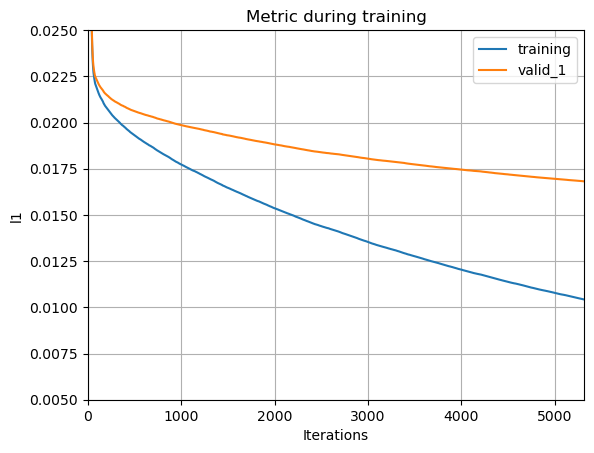

In [18]:
model = lgb.LGBMRegressor(**best_params,
                          n_jobs = -1,
                          random_state = 1234)

model.fit(X_train, y_train, 
          eval_set = [(X_train, y_train),
                      (X_valid, y_valid)],
          verbose = 100, 
          early_stopping_rounds = 100) 
lgb.plot_metric(model, ylim = (0.005, 0.025))

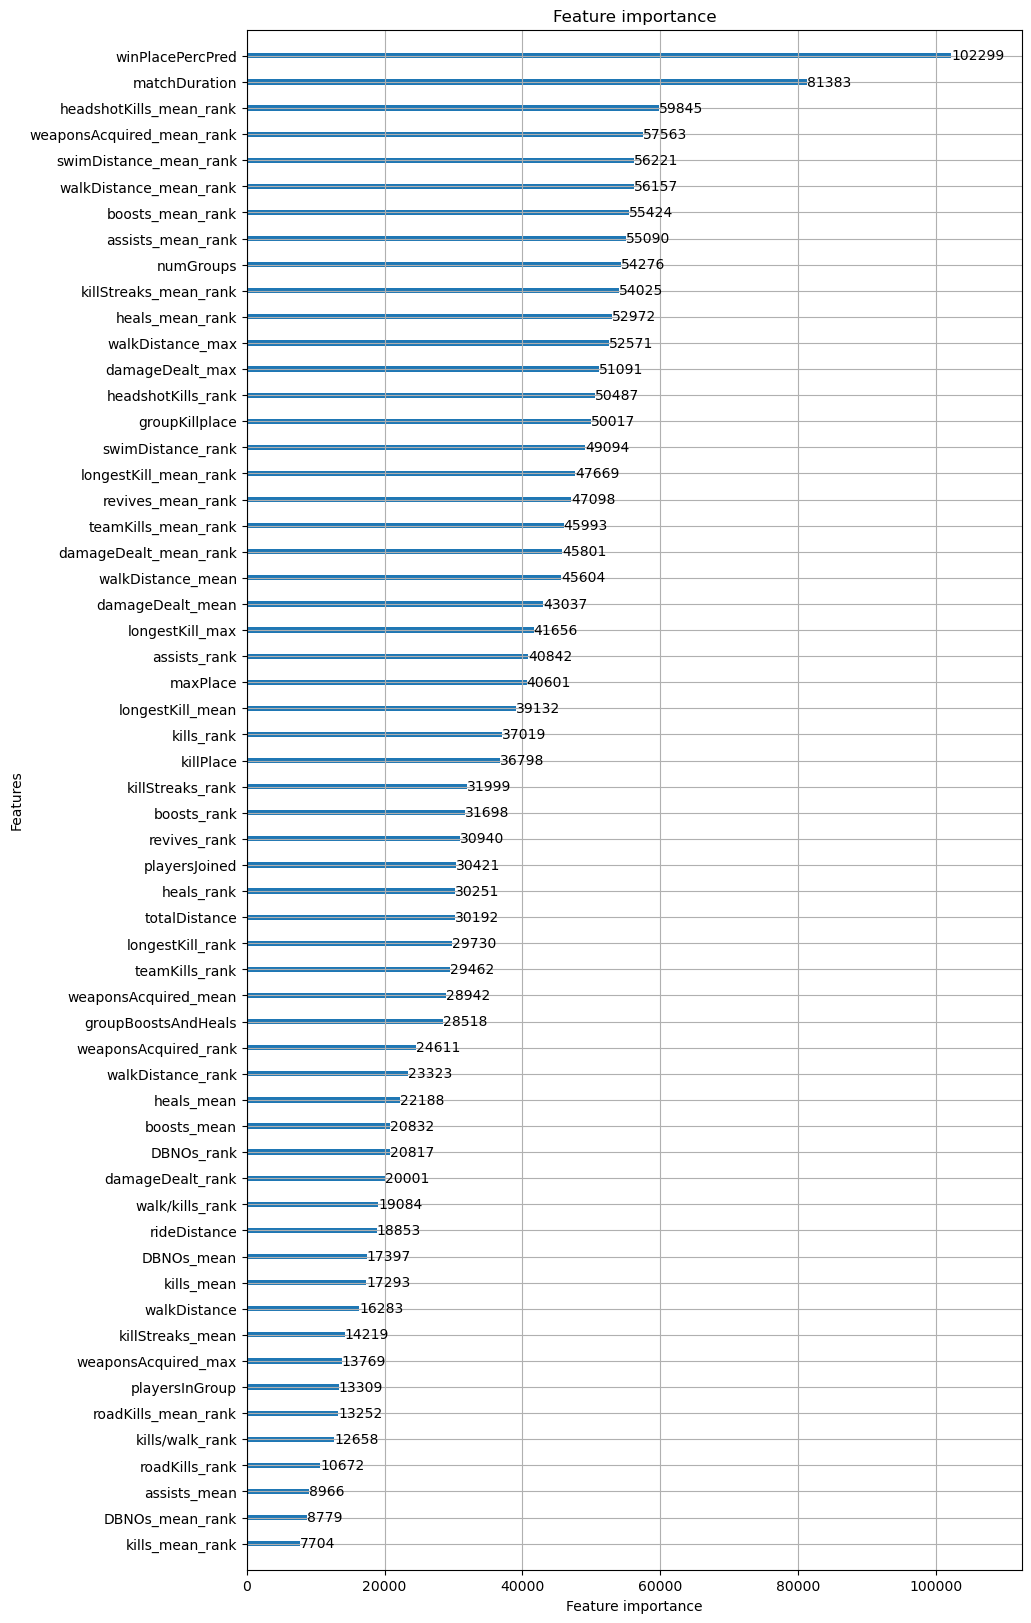

In [19]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize = (10, 20))
lgb.plot_importance(model, ax = ax)
plt.show()

In [20]:
pred = model.predict(test)

test = pd.concat([test, test_post], axis = 1)
test['winPlacePercPred'] = pred
test_post_matches = test['matchId'].unique()

In [21]:
rank_dictionary = {} 
total = len(test_post_matches)
i = 0

for tpm in test_post_matches : 
    try :
        postprocessing_func(test, tpm)
    except : 
        print('error : ', tpm)
    if i % 1000 == 0 : 
        print(f'progress : {i}/{total} ({np.round(i/total*100)})%')
    i += 1 
winPlacePercPred_postprocessing = test['groupId'].map(rank_dictionary)

progress : 0/20556 (0.0)%
progress : 1000/20556 (5.0)%
progress : 2000/20556 (10.0)%
progress : 3000/20556 (15.0)%
progress : 4000/20556 (19.0)%
progress : 5000/20556 (24.0)%
progress : 6000/20556 (29.0)%
progress : 7000/20556 (34.0)%
progress : 8000/20556 (39.0)%
progress : 9000/20556 (44.0)%
progress : 10000/20556 (49.0)%
progress : 11000/20556 (54.0)%
progress : 12000/20556 (58.0)%
progress : 13000/20556 (63.0)%
progress : 14000/20556 (68.0)%
progress : 15000/20556 (73.0)%
progress : 16000/20556 (78.0)%
progress : 17000/20556 (83.0)%
progress : 18000/20556 (88.0)%
progress : 19000/20556 (92.0)%
progress : 20000/20556 (97.0)%


In [22]:
submission = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv')
submission['winPlacePerc'] = winPlacePercPred_postprocessing

if submission.isnull().sum().sum() > 0 : 
    print('error')
    submission = submission.fillna(0, inplace = True)
submission.to_csv('submission.csv', index = False)